In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

df = pd.read_excel('축산유통정보_한우돼지도매가격_일범_230227.xlsx', sheet_name='한우_도매가격')

In [2]:
def trend(x):
    if re.search('▼', x):
        symbol = -1
    elif re.search('▲', x):
        symbol = 1
    else:
        return np.nan

    x = re.split('▼|▲', x)[1]
    x= re.sub(',|-| ', '', x)

    return float(x) * symbol

df = df.iloc[4:, :2]
df.columns = ['date', 'price']

df['trend'] = df['price'].apply(trend)
df['price'] = df['price'].apply(lambda x: re.split('▼|▲', x)[0] if re.search('▼|▲', x) else x)

df['date'] = pd.to_datetime(df['date'])
df.sort_values(by='date', inplace=True)
df.dropna(inplace=True)

df['price'] = df['price'].apply(lambda x: re.sub(',|-| ', '', x))
df['price'] = df['price'].astype(float)

df.index = range(len(df))

[I 2023-02-28 01:01:56,591] A new study created in memory with name: no-name-c6f42841-6eea-4cdf-abd7-f3d0a7501330
[I 2023-02-28 01:01:56,642] Trial 0 finished with value: 2.8300083515443606 and parameters: {'max_depth': 6, 'n_estimators': 81}. Best is trial 0 with value: 2.8300083515443606.
[I 2023-02-28 01:01:56,942] Trial 1 finished with value: 0.9820348423587058 and parameters: {'max_depth': 8, 'n_estimators': 433}. Best is trial 1 with value: 0.9820348423587058.
[I 2023-02-28 01:01:57,144] Trial 2 finished with value: 1.6838911940049883 and parameters: {'max_depth': 5, 'n_estimators': 391}. Best is trial 1 with value: 0.9820348423587058.
[I 2023-02-28 01:01:57,342] Trial 3 finished with value: 2.1133785307324677 and parameters: {'max_depth': 4, 'n_estimators': 435}. Best is trial 1 with value: 0.9820348423587058.
[I 2023-02-28 01:01:57,408] Trial 4 finished with value: 2.1067479723864144 and parameters: {'max_depth': 9, 'n_estimators': 82}. Best is trial 1 with value: 0.98203484235

<AxesSubplot:xlabel='date'>

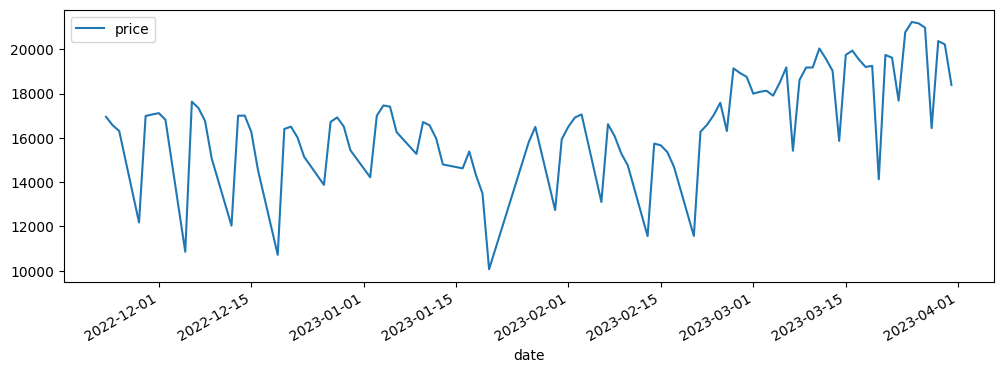

In [49]:
from pmdarima.arima import auto_arima

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

from datetime import timedelta
from datetime import datetime
import optuna

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

data = df[df['date'] >= '2020-01-01'].copy()
data_cp = df[df['date'] >= '2020-01-01'].copy()

data['price_lead_1'] = data['price'].shift(-1)
data['trend_lead_1'] = data['trend'].shift(-1)

data.dropna(inplace=True)

train_X, train_y = data[['trend']].values, data['trend_lead_1'].values

end_date = datetime.strptime('2023-03-31', '%Y-%m-%d')

def GB_objective(trial):
    max_depth = trial.suggest_int('max_depth', 1, 10)
    # max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 1000)
    n_estimators =  trial.suggest_int('n_estimators', 1, 500)
   
    model = GradientBoostingRegressor(
        max_depth = max_depth, 
        # max_leaf_nodes = max_leaf_nodes, 
        n_estimators = n_estimators, 
        # random_state=25
    )
    model.fit(train_X, train_y)

    train_pred = model.predict(train_X)
    
    return mean_absolute_percentage_error(train_y, train_pred)
    
#Execute optuna and set hyperparameters
GB_study = optuna.create_study(direction='minimize')
GB_study.optimize(GB_objective, n_trials=50)

# {'max_depth': 10, 'max_leaf_nodes': 990, 'n_estimators': 498}

optimized_GB = GradientBoostingRegressor(
    max_depth = GB_study.best_params['max_depth'], 
    # max_leaf_nodes = GB_study.best_params['max_leaf_nodes'],
    n_estimators = GB_study.best_params['n_estimators'],
    # random_state=25
)

optimized_GB.fit(train_X, train_y)

while data_cp.iloc[-1].date < end_date:
    last_row = data_cp.iloc[-1]

    # new_prediction = model.predict(data_cp[['trend']].iloc[[-1]].values).item()
    new_trend = optimized_GB.predict(data_cp[['trend']].iloc[[-1]].values).item()
    
    new_date  = last_row.date + timedelta(days=1)
    new_row = [
        new_date,
        last_row.price + new_trend,
        new_trend,
    ]

    # concate new row to data_cp, and keep index in order
    data_cp = pd.concat([data_cp, pd.DataFrame([new_row], columns=['date', 'price', 'trend'])], ignore_index=True)

data_cp[-100:].plot(x='date', y='price', figsize=(12, 4))

In [58]:
data_cp[data_cp['date'] >= '2023-03-01']#.to_clipboard(index=False)

,date,price,trend
794,2023-03-01,17992.828028,-760.372798
795,2023-03-02,18079.333660,86.505632
796,2023-03-03,18124.739055,45.405395
797,2023-03-04,17905.362986,-219.376069
798,2023-03-05,18487.828788,582.465801
799,2023-03-06,19182.096407,694.267619
800,2023-03-07,15417.495550,-3764.600856
801,2023-03-08,18614.343629,3196.848079
802,2023-03-09,19171.971767,557.628137
803,2023-03-10,19176.034048,4.062281


<AxesSubplot:xlabel='date'>

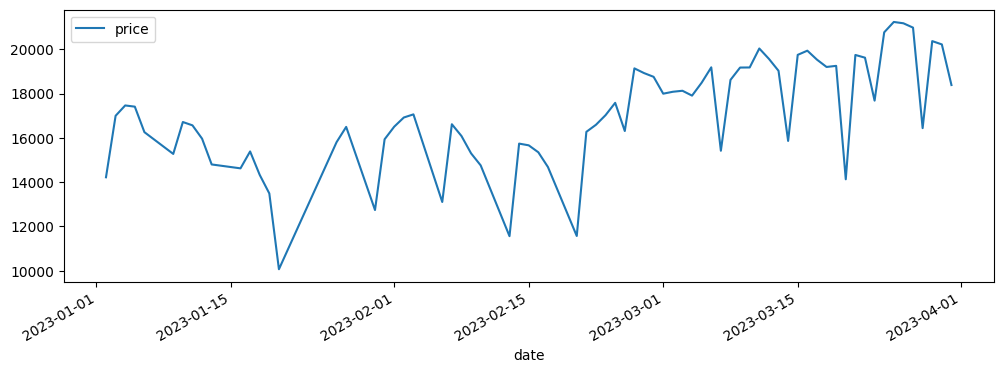

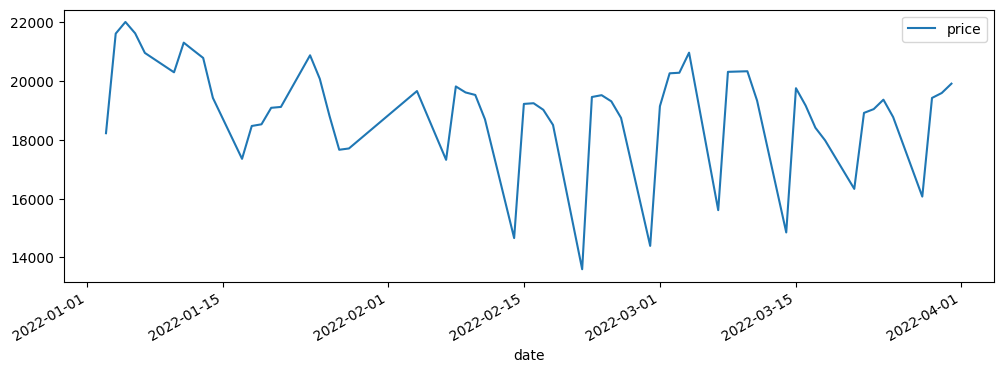

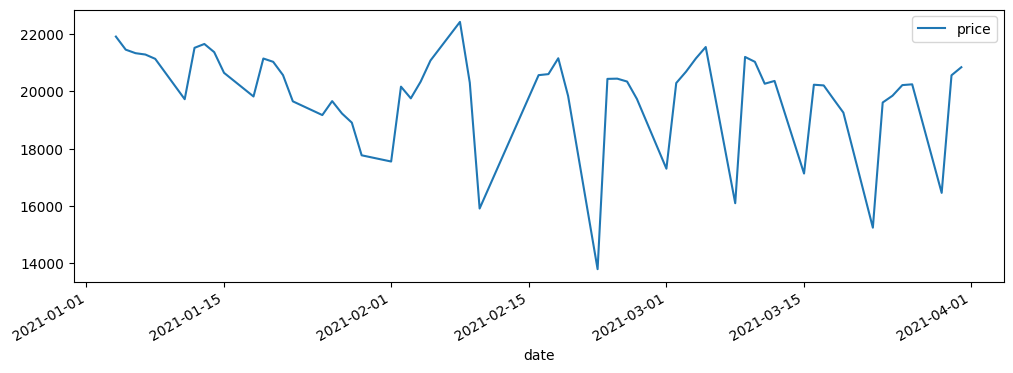

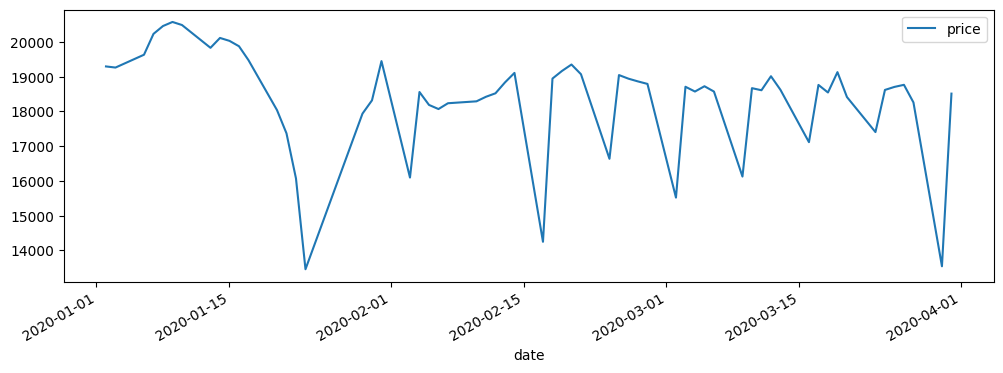

In [54]:
data_cp[(data_cp['date'] >= '2023-01-01') & (data_cp['date'] <= '2023-03-31')].plot(x='date', y='price', figsize=(12, 4))

data_cp[(data_cp['date'] >= '2022-01-01') & (data_cp['date'] <= '2022-03-31')].plot(x='date', y='price', figsize=(12, 4))

data_cp[(data_cp['date'] >= '2021-01-01') & (data_cp['date'] <= '2021-03-31')].plot(x='date', y='price', figsize=(12, 4))

data_cp[(data_cp['date'] >= '2020-01-01') & (data_cp['date'] <= '2020-03-31')].plot(x='date', y='price', figsize=(12, 4))